In [4]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from lib.fno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDataset

In [5]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [6]:
modes = 16
width = 64
layers = 2
fno = FNO1d(modes, width, layers)  # model

# load model weights
fno.load_state_dict(torch.load("models/fno_model.pth", weights_only=True, map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
BATCH_SIZE = 10

In [8]:
test_data = PDEDataset("data/test_sol_OOD.npy")
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:

        prediction = fno(input).squeeze(-1)

        loss = torch.mean(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()

test_relative_l2 /= len(test_data_loader)
print(f"Test relative L2 error: {test_relative_l2}")

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 91.70it/s]

Test relative L2 error: 0.09246397935427152


In [10]:
# pick N random samples and draw prediction and target
N = 6
samples = DataLoader(test_data, batch_size=1, shuffle=True)

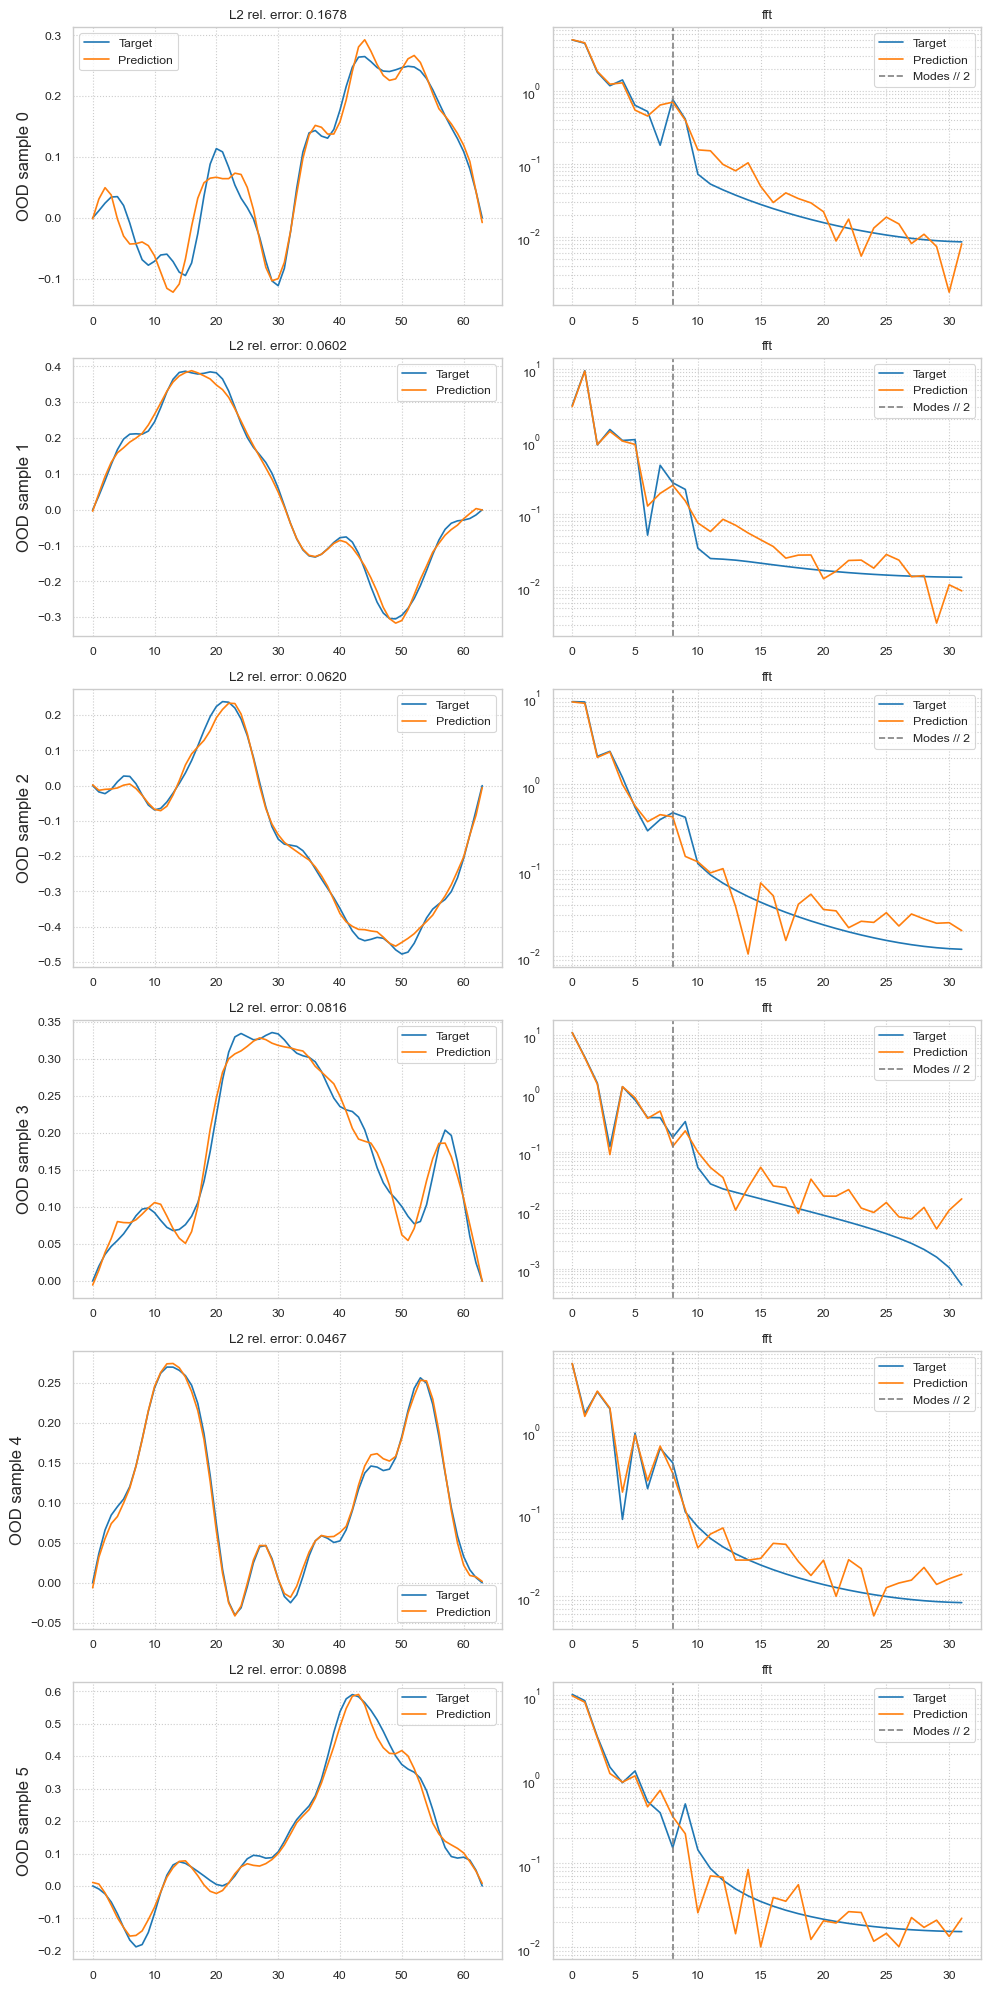

In [11]:
fig, axs = plt.subplots(6, 2, figsize=(10, 20))

fno.eval()
with torch.no_grad():
    for i, (ax_rows, sample) in enumerate(zip(axs, samples)):
        input, target = sample

        prediction = fno(input).squeeze(-1)

        re_l2_error = relative_l2_error(prediction, target).item()

        ax = ax_rows[0]

        ax.set_ylabel(f"OOD sample {i}", fontsize=12)

        ax.plot(
            target.squeeze(0).numpy(),
            label="Target",
        )
        ax.plot(
            prediction.squeeze(0).numpy(),
            label="Prediction",
        )

        ax.set_title(f"L2 rel. error: {re_l2_error:.4f}")

        ax.legend()
        ax.grid(True, which="both", ls=":")

        ax = ax_rows[1]
        ax.set_yscale("log")

        # plot freqiencies spectrum of target and prediction
        target_fft = np.fft.fft(target.squeeze(0).numpy())
        prediction_fft = np.fft.fft(prediction.squeeze(0).numpy())

        ax.plot(
            np.abs(target_fft)[: len(target_fft) // 2],
            label="Target",
        )

        ax.plot(
            np.abs(prediction_fft)[: len(prediction_fft) // 2],
            label="Prediction",
        )

        ax.axvline(modes // 2, color="gray", ls="--", label="Modes // 2")

        ax.set_title("fft")
        ax.legend()
        ax.grid(True, which="both", ls=":")

plt.tight_layout()
plt.show()